In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit
import warnings
import json
from helper_functions import find_dips, find_index
from wafer_plot import draw_wafer_plot

warnings.filterwarnings('ignore')

In [24]:
def sin_func(x, a, b, c, phi):
    return (a + b * x) * (np.sin(c * (x - 1310) - phi)) ** 2

def lin_func(x, A, B):
    return A * x ** 2 + B * x

In [3]:
root_path = Path('/Users/jiahaozhan/Google Drive/Other Computers/CM300/Dione_wafer3_BO')
data_path = root_path / 'pdk_thermphase_test_cells'

no = 0
data_dir_gen = sorted(data_path.glob(f'reticle27/*.json'))
for d in data_dir_gen:
    df = pd.read_json(d)
    # print(df.columns)
    # print(df['wavelength'])
    # ret = int(df['reticle'][0])
    
    wavel = df['wavelength'][no]
    trans = df['transmission_ch1'][no]
    volts = df['smu_voltage'][no]
    currs = df['smu_current'][no]

currs = [i - currs[0] for i in currs] # current should be 0 at 0 V
currs_mA = np.multiply(currs, 1000)

elec_pwrs = np.multiply(volts, currs_mA)
res = np.divide(volts[1:], currs[1:])

print(currs_mA)
print(res)
print(type(trans))

[ 0.         3.3686129  6.6816479 10.0338529 13.1065349 16.1177149
 18.9996649 21.7279849 24.3848649 26.7950249 29.0504849 31.1634749
 33.1287249 35.0170849 36.7132049 38.2928849 39.7563349 41.1154649
 42.3817249 43.5897849 44.6491449 45.5970849 46.1244649 36.7135749
 34.0966849 32.7184249]
[29.68580925 29.93273561 29.89878395 30.51912676 31.02176724 31.57950433
 32.21651723 32.80723528 33.58832482 34.42283333 35.29773247 36.2223419
 37.12473507 38.13341831 39.17176791 40.24515851 41.34697258 42.47113595
 43.58819399 44.793691   46.0555758  47.6970303  62.64712729 70.38807459
 76.40954623]
<class 'list'>


(1306.0, 1315.0)

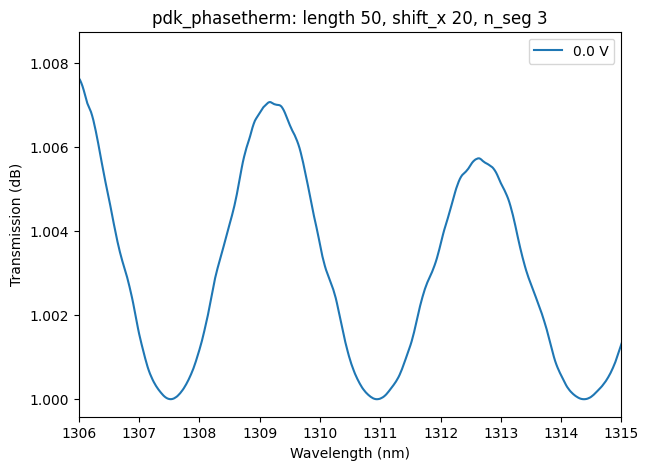

In [4]:
# plot tranmission spectra at different voltages
trans_mW = [10 ** np.divide(tr, 10) for tr in trans]

title = f"pdk_phasetherm: length {df['length'][no]}, shift_x {df['shift_x'][no]}, n_seg {df['n_seg'][no]}"
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for i in [0]:
    ax.plot(wavel, 10 ** np.divide(trans_mW[i], 10), label=f'{volts[i]:.2} V')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Transmission (dB)')
ax.set_title(title)
ax.legend()
ax.set_xlim([1306, 1315])
# ax.text(xlim[1]-2, -61, '$P_{\pi}$ = ' + f'{P_pi:.2f} mW', fontsize=12)

[0.8811399319030084, 0.9120941760559691, 1.024414527885401, 1.225449439549941, 1.496819684500773, 1.8536419047885349, 2.3065931921222664, -0.2875592868478659, 0.3302704583647591, 0.9609883612291463, 1.6484494045102218, 2.4386553447290304, 0.16588988498451523, 1.0552406490050616, 1.96757166504114, -0.1360288365597901, 0.8848103158919545, 1.9322071095756548, -0.035113191574289083, 1.1393520431134785, 2.325322422972423, 0.4269575462068898, 0.8501866110001346, 2.057363034389688, 2.3640644337286645, -0.39877395703202045]


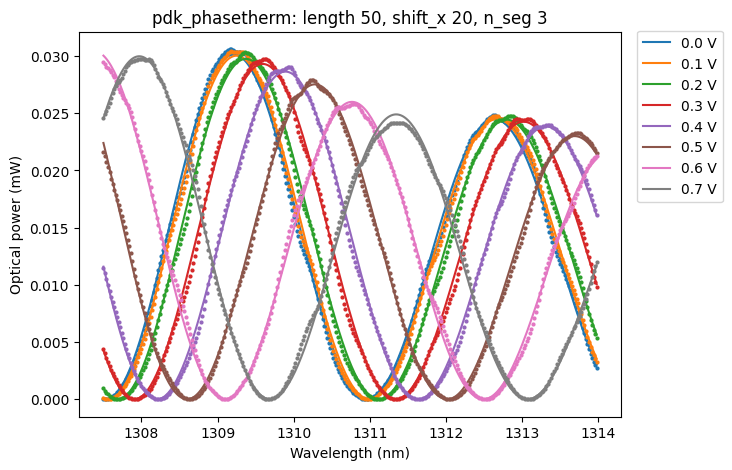

In [46]:
# fit the transmission spectra with the defined function
wl_range = [1307.5, 1314]
idx = [find_index(wl, wavel) for wl in wl_range]
ph_shift_raw = []

# y_predicted = sin_func(x_data, *p_opt)
# residuals = y_data - y_predicted
# ss_total = np.sum((y_data - np.mean(y_data))**2)
# ss_residual = np.sum(residuals**2)
# r_squared = 1 - (ss_residual / ss_total)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
ax = axes
for i in range(len(volts)):
    x_data, y_data = np.array(wavel[idx[0]:idx[1]]), np.array(trans_mW[i][idx[0]:idx[1]])
    p_opt, p_cov = curve_fit(sin_func, x_data, y_data)
    if i in [0, 1, 2 ,3, 4, 5, 6, 7]:
        ax.plot(x_data, y_data, 'o', markersize=2, color=colors[i%len(colors)])
        ax.plot(x_data, sin_func(x_data, *p_opt), color=colors[i%len(colors)],
                label=f'{volts[i]:.2} V') #, ' + '$\phi$ = ' + f'{p_opt[3]:.2f} rad')
    ph_shift_raw.append(p_opt[3])
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Optical power (mW)')
ax.set_title(title)
ax.legend(bbox_to_anchor = (1.2, 0.78), loc='center right')

print(ph_shift_raw)

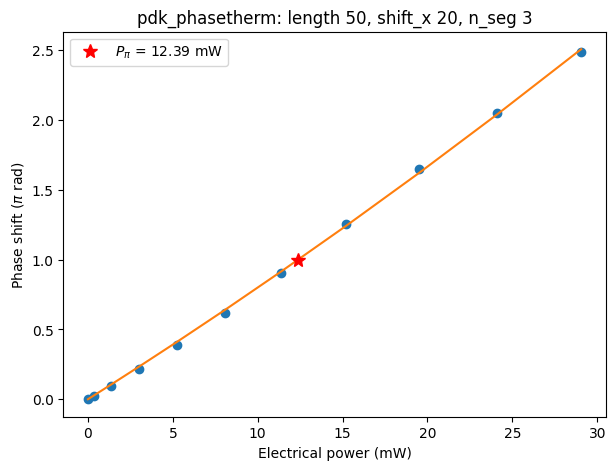

In [33]:
ph_shift_single_raw = np.multiply(ph_shift_raw, 2)
ph_shift_single = [ps - ph_shift_single_raw[0] for ps in ph_shift_single_raw]
# unfold the phase shift data
for i in range(1, len(ph_shift_single)):
    if ph_shift_single[i] < ph_shift_single[i-1]:
        ph_shift_single[i:] = [ph + 2*np.pi for ph in ph_shift_single[i:]]

x_data, y_data = elec_pwrs[:11], np.divide(ph_shift_single[:11], np.pi)
p_opt, p_cov = curve_fit(lin_func, x_data, y_data)

p_math = np.roots([*p_opt, -1])
P_pi = p_math[1]
        
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
ax = axes
ax.plot(x_data, y_data, 'o')
ax.plot(x_data, lin_func(x_data, *p_opt))
ax.plot(P_pi, 1, '*', color='r', markersize=10, label='$P_{\pi}$ = ' + f'{P_pi:.2f} mW')
ax.set_xlabel('Electrical power (mW)')
ax.set_ylabel('Phase shift ($\pi$ rad)')
ax.set_title(title)
ax.legend()